# MLP

This describes a Multilayer Perceptron trained to predict the next character, following the 2003 paper by Bengio et al. We use embeddings to improve the neural net. Initially, we have a matrix of embeddings ($C$) that returns 2 parameters for each character. This structure is more scalable; for example, if we had 17,000 words instead of 26 characters, we could convert those words into a 30-dimensional tensor, which is easier to use. 

We first use 3 characters to predict the next one, so we have to embed 3 characters.Then, we insert this information into a 100-neuron layer that produces 100 outputs. These are passed to a $\tanh$ function to introduce non-linearity. 

Finally, we pass these 100 outputs to a last layer of 27 neurons, which gives us 27 outputs. To convert that information into probabilities, we use a softmax function to predict the next character



Now 

In [762]:
import torch
import torch.nn.functional as F

words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [763]:
chars = sorted(list(set(''.join(words))))
stoi = {k:i+1 for i,k in enumerate(chars)}
stoi['.'] = 0
itos = {i:k for k,i in stoi.items()}

In [843]:
import random
blockSize = 5
def train_set (wor):
    X,Y = [], []

    for w in wor:
        context = [0] * blockSize
        w = w + '.'
        for ch in w: 
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)   
    return X, Y


n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

random.seed(42)
random.shuffle(words)

Xtr, Ytr = train_set(words[:n1])
Xdev, Ydev = train_set(words[n1:n2])
Xte, Yte = train_set(words[n2:])


THE INITIALIZATION IS VERY IMPORTANT!!!!!!!!!!

init.kaiming_normal(m.weight.data, mode='fan_in',nonlinearity = 'kTanh' )


In [ ]:
g = torch.Generator().manual_seed(2147483647)   # For having always the same result 
embbeding_dim = 7
n_hidden = 200

# Embedding table 
C = torch.randn((27,embbeding_dim), generator=g ) 
# Hidden Layer
W1 = torch.randn((embbeding_dim*blockSize,n_hidden), generator=g)  * (5/3)/((embbeding_dim * blockSize)**0.5) #* 0.2  # Weights
# b1 = torch.randn(n_hidden, generator=g)                 # bias

# BatchNorm layer 
bngain = torch.ones((1, n_hidden))          # One because is only one value 
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# Output Layer
W2 = torch.randn((n_hidden,27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0


parameters = [C, W1, W2, b2, bngain, bnbias]

In [872]:
sum(p.nelement() for p in parameters)       # Number of parameters

13016

In [873]:
for p in parameters:
    p.requires_grad = True 

In [858]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [875]:
lri = []
lossi = []
n_rate= 0.0001

for i in range(100000):

    # minibatch
    ix = torch.randint(0,Xtr.shape[0],(32,))

    # Forward pass
    emb = C[Xtr[ix]]

    hpreact = emb.view(-1,embbeding_dim*blockSize) @ W1 # + b1 the bias is redundant

      # BatchNorm layer
   # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
   # -------------------------------------------------------------
    # Non-linearity
    logits = hpreact @ W2 + b2

    loss = F.cross_entropy(logits,Ytr[ix])
    # Backward pass
    for p in parameters:
        p.grad = None 
    loss.backward()

    # Update 
    for p in parameters:
        p.data += -(0.1 if i<100000 else 0.01)*p.grad 
    #Store data
    if (i%10000==0):
        print(f'(Perdida de {loss.item()} en la vuelta {i})')
    
print (loss.item())



(Perdida de 24.995807647705078 en la vuelta 0)
(Perdida de 2.9372622966766357 en la vuelta 10000)
(Perdida de 2.8226215839385986 en la vuelta 20000)
(Perdida de 2.3966009616851807 en la vuelta 30000)
(Perdida de 2.2133078575134277 en la vuelta 40000)
(Perdida de 2.7904889583587646 en la vuelta 50000)
(Perdida de 2.308730125427246 en la vuelta 60000)
(Perdida de 2.461207389831543 en la vuelta 70000)
(Perdida de 2.349693536758423 en la vuelta 80000)
(Perdida de 2.316053867340088 en la vuelta 90000)
2.28867506980896


In [876]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2924177646636963
val 2.296923875808716


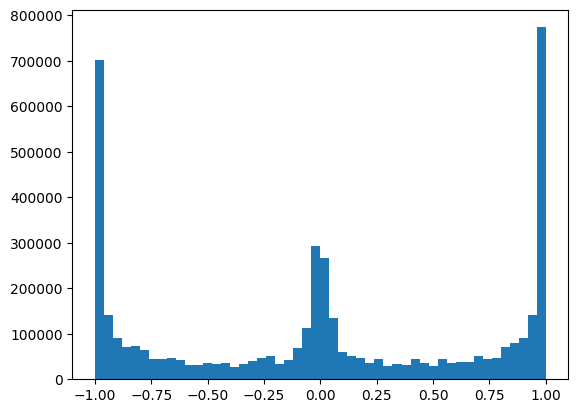

In [838]:
plt.hist(h.view(-1).tolist(),50);

In [851]:
emb = C[Xte]
h = (emb.view(-1,embbeding_dim*blockSize) @ W1 + b1).tanh()
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Yte)
print(loss.item())

2.0602619647979736


In [854]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(50): 
    out = []
    context = [0] * blockSize # Initialize with '...' (index 0)
    while True: 
        emb = C[torch.tensor([context])] # (1, 3, 5)
        h = (emb.view(1, -1) @ W1 + b1).tanh()
        logits = h @ W2 + b2
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True) # <--- FIX 1: Sum over dim 1
        
        ix = torch.multinomial(probs, num_samples=1, generator=g).item() 
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0: # <--- FIX 2: Break on 0 ('.')
            break
            
    print(''.join(itos[i] for i in out[:-1])) # Print word excluding the final dot

celia
moglen
kilari
ahnell
imitna
nolla
kamaria
samiyah
javerii
tai
morie
cavo
kentedo
kaley
maside
eniav
jaylynn
periciel
viah
asu
jadriel
jolen
alaisa
jarriel
jayzley
ernis
rhyleni
ajbwiabeah
hariya
qerenleigh
aah
keenan
jaisley
javayah
lockor
gaptenix
eversos
cayenne
illy
nahmie
meenna
mahkam
xemin
ashcren
alchah
cioro
alve
selane
nechay
rano


## ENERGY IMPLEMENTATION

In [775]:
import torch
import torch.nn.functional as F

# Setup (Assuming you have these from your previous cells)
g = torch.Generator().manual_seed(2147483647)
vocab_size = 27
block_size = 3
embedding_dim = 10
hidden_dim = 200

# --- 1. MODEL INITIALIZATION ---
C = torch.randn((vocab_size, embedding_dim), generator=g)

# NEW: W1 input size increases by 1 embedding_dim because we add the target char
# Input: [Context (3) + Target (1)] * dim
W1 = torch.randn((embedding_dim * (block_size + 1), hidden_dim), generator=g) 
b1 = torch.randn(hidden_dim, generator=g)

# NEW: Output is 1 scalar energy score, not 27 class probabilities
W2 = torch.randn((hidden_dim, 1), generator=g)
b2 = torch.randn(1, generator=g) # Single bias for the energy function

parameters = [C, W1, b1, W2, b2]
for p in parameters: p.requires_grad = True


In [776]:

n_rate = 0.0001
lr = 0.01

# --- 2. TRAINING LOOP ---
for i in range(100000):
    
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # --- VECTORIZED ENERGY CALCULATION ---
    
    # A. Get Context Embeddings: (32, 3, 7) -> (32, 21)
    # This is the "Question"
    ctx_emb = C[Xtr[ix]].view(-1, embedding_dim * block_size)
    
    # B. Get Candidate Embeddings: (27, 7)
    # These are the possible "Answers". We want to test ALL of them.
    all_candidates = torch.arange(vocab_size)
    cand_emb = C[all_candidates] 
    
    # C. Combine them: We need every context paired with every candidate.
    # We expand dimensions to broadcast:
    # Context: (32, 1, 21)  <- repeated 27 times along dim 1
    # Cand:    (1, 27, 7)   <- repeated 32 times along dim 0
    ctx_expanded = ctx_emb.unsqueeze(1).expand(-1, vocab_size, -1)
    cand_expanded = cand_emb.unsqueeze(0).expand(32, -1, -1)
    
    # Concatenate: (32, 27, 28) -> (Batch, Vocab, Total_Input_Features)
    # This input contains [Context, Candidate] for every possibility
    combined_input = torch.cat((ctx_expanded, cand_expanded), dim=2)
    
    # D. Forward Pass (Energy Function)
    # Flatten to pass through linear layer: (32*27, 28)
    h = (combined_input.view(-1, embedding_dim * (block_size + 1)) @ W1 + b1).tanh()
    
    # Energy Output: (32*27, 1) -> Reshape to (32, 27)
    # These are your "logits" - one score for every candidate
    logits = (h @ W2 + b2).view(32, vocab_size)
    
    # --- LOSS & UPDATE ---
    loss = F.cross_entropy(logits, Ytr[ix])

    for p in parameters: p.grad = None 
    loss.backward()
    for p in parameters: p.data += -lr * p.grad 

print(loss.item())

2.5773987770080566


In [777]:
@torch.no_grad() # Disable gradient tracking for speed
def evaluate_energy_model(X, Y, batch_size=32):
    total_loss = 0
    steps = 0
    
    # We process the dev set in batches to avoid running out of RAM
    # (Since we are expanding every example by 27 times!)
    for i in range(0, X.shape[0], batch_size):
        # 1. Get Batch
        X_batch = X[i:i+batch_size]
        Y_batch = Y[i:i+batch_size]
        
        # 2. Vectorized Expansion (Same as training)
        # Context: (Batch, 3) -> (Batch, 1, 21) -> (Batch, 27, 21)
        ctx_emb = C[X_batch].view(X_batch.shape[0], -1) # Flatten context
        ctx_expanded = ctx_emb.unsqueeze(1).expand(-1, vocab_size, -1)
        
        # Candidates: (27) -> (1, 27, 7) -> (Batch, 27, 7)
        cand_emb = C[torch.arange(vocab_size)]
        cand_expanded = cand_emb.unsqueeze(0).expand(X_batch.shape[0], -1, -1)
        
        # Combine: (Batch, 27, 28)
        combined_input = torch.cat((ctx_expanded, cand_expanded), dim=2)
        
        # 3. Forward Pass
        # Flatten for Linear Layer: (Batch * 27, 28)
        h = (combined_input.view(-1, embedding_dim * (block_size + 1)) @ W1 + b1).tanh()
        logits = h @ W2 + b2
        
        # Reshape back to (Batch, 27) to compare with Y_batch
        logits = logits.view(X_batch.shape[0], vocab_size)
        
        # 4. Calculate Loss
        loss = F.cross_entropy(logits, Y_batch)
        total_loss += loss.item()
        steps += 1
        
    return total_loss / steps

# --- RUN COMPARISON ---
print("Evaluating Energy Model on Dev Set...")
dev_loss = evaluate_energy_model(Xdev, Ydev)
print(f"Energy Model Dev Loss: {dev_loss:.4f}")

Evaluating Energy Model on Dev Set...
Energy Model Dev Loss: 2.3220


__________________

# PLAYGROUND ZONE

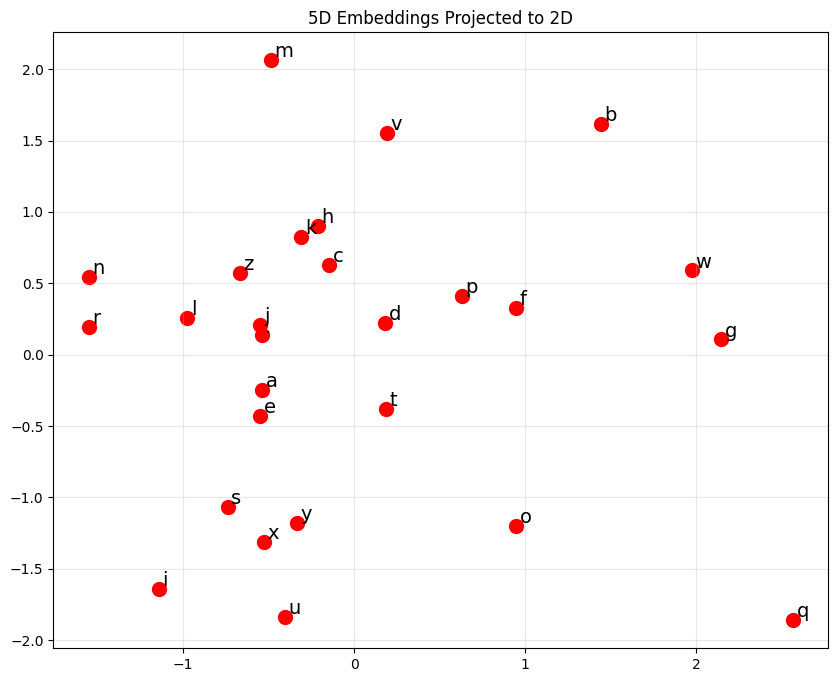

In [596]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Prepare the data
# Assuming 'C' is your parameter matrix with shape [27, 5]
# We detach it from the graph and convert to numpy
embeddings = C.detach().numpy()

# 2. Reduce from 5 dimensions to 2 dimensions
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# 3. Plot the result
plt.figure(figsize=(10, 8))

# Scatter plot of the x and y coordinates
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=100, color='red')

# 4. Add text labels for each character
# We need the list of characters that correspond to the rows of C
# (Make sure this list matches the order in your 'stoi' dictionary)
chars = ['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
         'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

for i, char in enumerate(chars):
    # Place text at the (x, y) coordinates
    plt.text(embeddings_2d[i, 0] + 0.02, embeddings_2d[i, 1] + 0.02, char, fontsize=14)

plt.title("5D Embeddings Projected to 2D")
plt.grid(True, alpha=0.3)
plt.show()

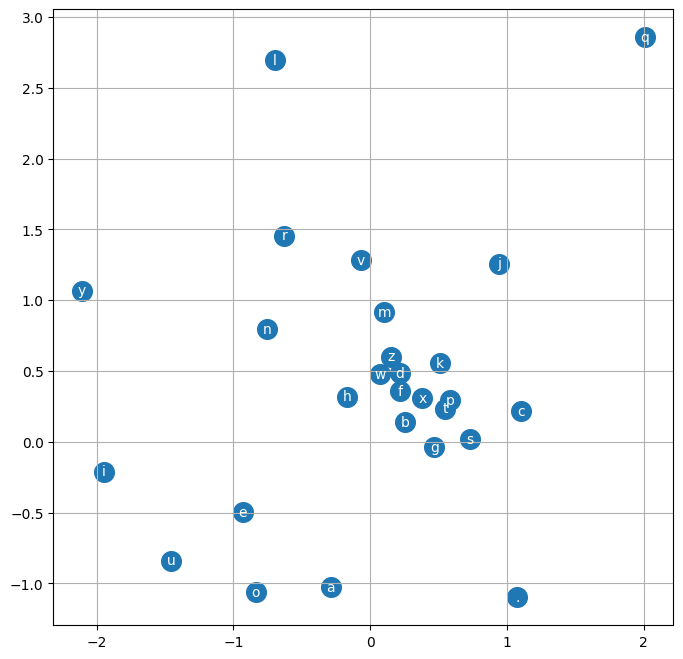

In [459]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

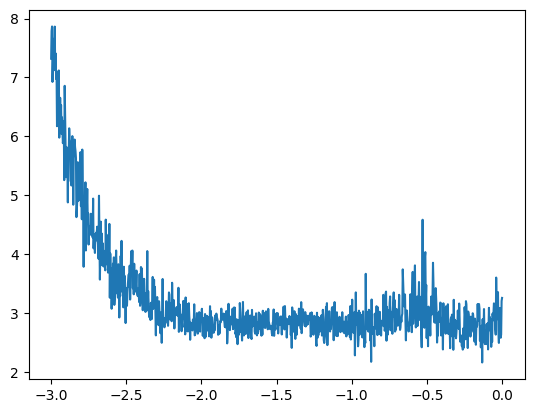

In [ ]:
import matplotlib.pyplot as plt

plt.plot(lri,lossi)
# 0.1 is a good one

70.15391540527344
64.75590515136719


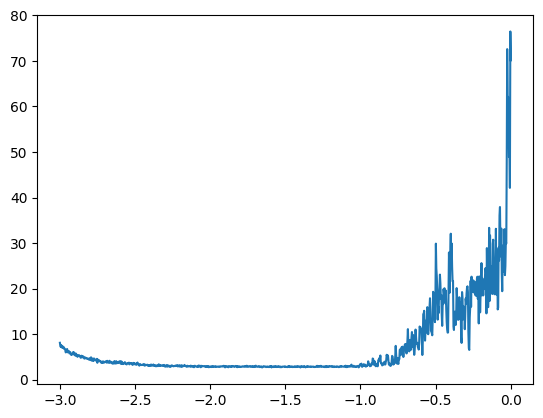

In [ ]:

g = torch.Generator().manual_seed(2147483647)   # For having always the same result 

n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

random.seed(42)
random.shuffle(words)

Xtr, Ytr = train_set(words[:n1])
Xdev, Ydev = train_set(words[n1:n2])
Xte, Yte = train_set(words[n2:])


embbeding_dim = 7

# Embedding table 
C = torch.rand((27,embbeding_dim), generator=g )

# Hidden Layer
W1 = torch.rand((embbeding_dim*blockSize,200), generator=g)   # Weights
b1 = torch.rand(200, generator=g)                    # bias 

# Output Layer
W2 = torch.rand((200,27), generator=g)
b2 = torch.rand(27, generator=g)

parameters = [C, W1, b1, W2, b2]

# Dev set 
for p in parameters:
    p.requires_grad = True 

lre = torch.linspace(-3,0,1000)
lrs = 10**lre
lri = []
lossi = []
n_rate= 0.0001

for i in range(1000):

    # minibatch
    ix = torch.randint(0,Xtr.shape[0],(200,))

    # Forward pass
    emb = C[Xtr[ix]]

    h = (emb.view(-1,embbeding_dim*blockSize) @ W1 + b1).tanh()
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits,Ytr[ix]) 

    # Backward pass
    for p in parameters:
        p.grad = None 
    loss.backward()

    # Update 
    for p in parameters:
        p.data += -(lrs[i])*p.grad 

    #Store data
    lri.append(lre[i])
    lossi.append(loss.item())

print (loss.item())


emb = C[Xdev]
h = (emb.view(-1,embbeding_dim*blockSize) @ W1 + b1).tanh()
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ydev)
print(loss.item())

import matplotlib.pyplot as plt

plt.plot(lri,lossi)
# 0.1 is a good one

Block Size   | Embed Dim  | Train Loss | Dev Loss  
--------------------------------------------------
2            | 3          | 2.6832       | 2.3751
2            | 4          | 2.6939       | 2.3707
2            | 5          | 1.7763       | 2.3907
2            | 6          | 2.2928       | 2.3400
2            | 7          | 2.1796       | 2.3477
2            | 8          | 2.1960       | 2.3756
2            | 9          | 2.3836       | 2.3372
2            | 10         | 2.6885       | 2.3805
3            | 3          | 2.7893       | 2.3276
3            | 4          | 2.1229       | 2.2979
3            | 5          | 2.3979       | 2.3050
3            | 6          | 2.1584       | 2.2930
3            | 7          | 2.6087       | 2.2908
3            | 8          | 3.5967       | 3.6525
3            | 9          | 3.7352       | 3.2093
3            | 10         | 3.7619       | 3.5166
4            | 3          | 2.5910       | 2.3222
4            | 4          | 2.1337       | 2.32

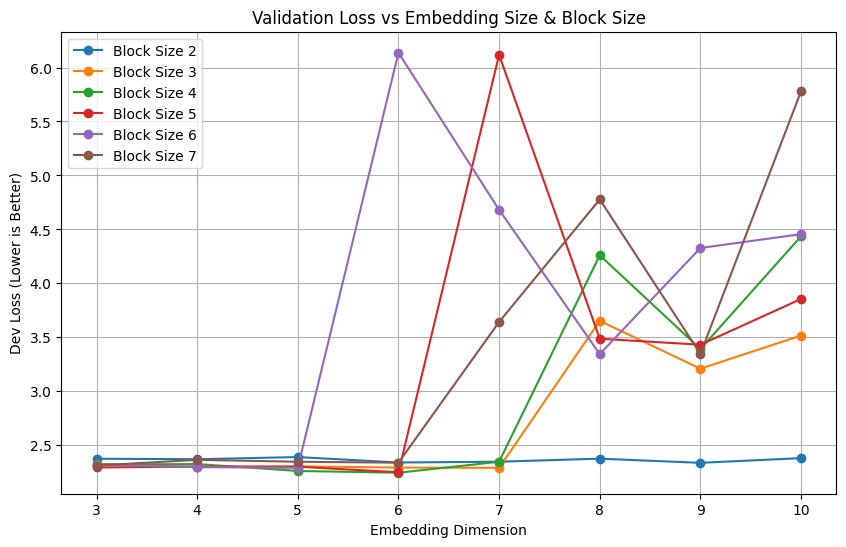

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import random

# --- 1. Load Data ---
# Ensure names.txt is in your working directory
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {k:i+1 for i,k in enumerate(chars)}
stoi['.'] = 0
itos = {i:k for k,i in stoi.items()}
vocab_size = len(stoi)

# Function to rebuild dataset with a specific block_size
def build_dataset(words, block_size):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# --- 2. Experiment Setup ---
# Define the values you want to test
block_sizes = [2, 3, 4, 5, 6, 7]       # Different context lengths
embedding_dims = [3, 4, 5, 6, 7, 8, 9, 10]  # Different vector sizes
results = {}

print(f"{'Block Size':<12} | {'Embed Dim':<10} | {'Train Loss':<10} | {'Dev Loss':<10}")
print("-" * 50)

# --- 3. Nested Loop Experiment ---
for block_size in block_sizes:
    # Important: Rebuild dataset because X depends on block_size
    Xtr, Ytr = build_dataset(words[:n1], block_size)
    Xdev, Ydev = build_dataset(words[n1:n2], block_size)
    
    for embedding_dim in embedding_dims:
        g = torch.Generator().manual_seed(2147483647)
        
        # Re-initialize parameters with new dimensions
        C = torch.rand((vocab_size, embedding_dim), generator=g)
        # Note: Input to W1 is (embedding_dim * block_size)
        W1 = torch.rand((embedding_dim * block_size, 200), generator=g)
        b1 = torch.rand(200, generator=g)
        W2 = torch.rand((200, vocab_size), generator=g)
        b2 = torch.rand(vocab_size, generator=g)
        
        parameters = [C, W1, b1, W2, b2]
        for p in parameters:
            p.requires_grad = True
            
        # Training Loop (Fixed LR for fair comparison)
        lr = 0.1
        n_rate = 0.0001
        steps = 20000 
        
        for i in range(steps):
            # Minibatch
            ix = torch.randint(0, Xtr.shape[0], (32,))
            
            # Forward pass
            emb = C[Xtr[ix]]
            # View inputs as flattened vector: (32, block_size * emb_dim)
            h = (emb.view(-1, embedding_dim * block_size) @ W1 + b1).tanh()
            logits = h @ W2 + b2
            
            # Loss with regularization
            loss = F.cross_entropy(logits, Ytr[ix]) 
            
            # Backward pass
            for p in parameters:
                p.grad = None
            loss.backward()
            
            # Update
            for p in parameters:
                p.data += -lr * p.grad
                
        # Evaluate on Dev Set
        with torch.no_grad():
            emb_dev = C[Xdev]
            h_dev = (emb_dev.view(-1, embedding_dim * block_size) @ W1 + b1).tanh()
            logits_dev = h_dev @ W2 + b2
            dev_loss = F.cross_entropy(logits_dev, Ydev).item()
            train_loss = loss.item()
            
        results[(block_size, embedding_dim)] = dev_loss
        print(f"{block_size:<12} | {embedding_dim:<10} | {train_loss:.4f}       | {dev_loss:.4f}")

# --- 4. Plot Results ---
plt.figure(figsize=(10, 6))
for bs in block_sizes:
    x = embedding_dims
    y = [results[(bs, ed)] for ed in embedding_dims]
    plt.plot(x, y, marker='o', label=f'Block Size {bs}')

plt.title('Validation Loss vs Embedding Size & Block Size')
plt.xlabel('Embedding Dimension')
plt.ylabel('Dev Loss (Lower is Better)')
plt.legend()
plt.grid(True)
plt.show()